In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested, daily_vaccinations, population_vaccinated
from phe import *
from phe import map_data as phe_map_data, latest_changes
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

In [2]:
latest_changes(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum)

Latest for England:
2,185 cases (7 day average) as of Wed 26 May, +121.0 since Tue 25 May
88 hospitalised (7 day average) as of Wed 26 May, +0.0 since Wed 26 May
5 died (7 day average) as of Wed 26 May, +0.9 since Tue 25 May


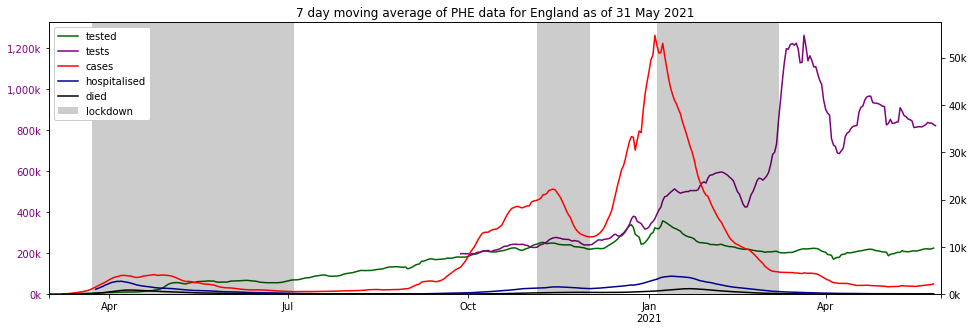

In [3]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

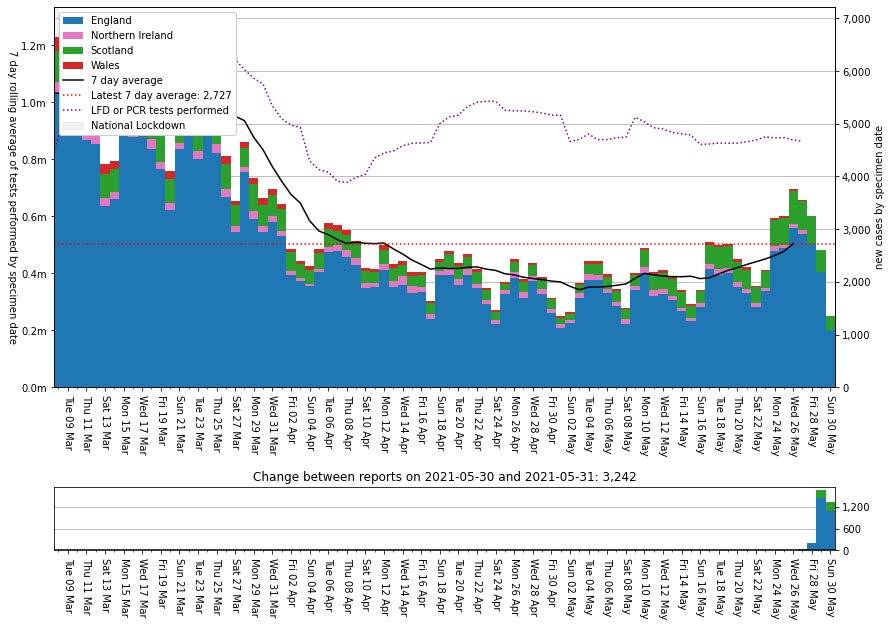

In [4]:
plot_areas(for_date, 'cases_nations', earliest=lockdown3[1], date_format='%a %d %b')

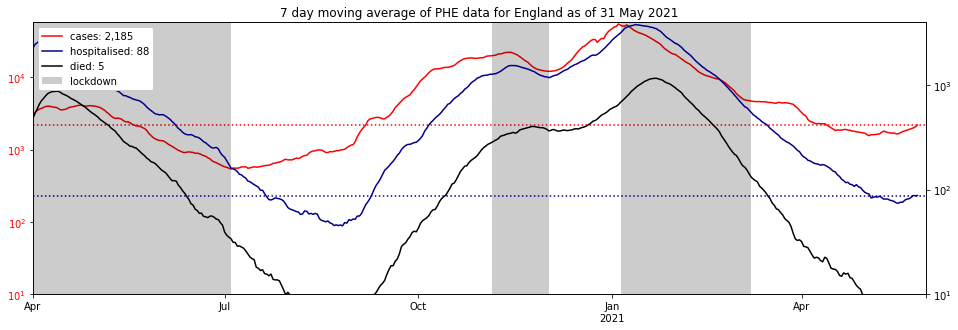

In [5]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

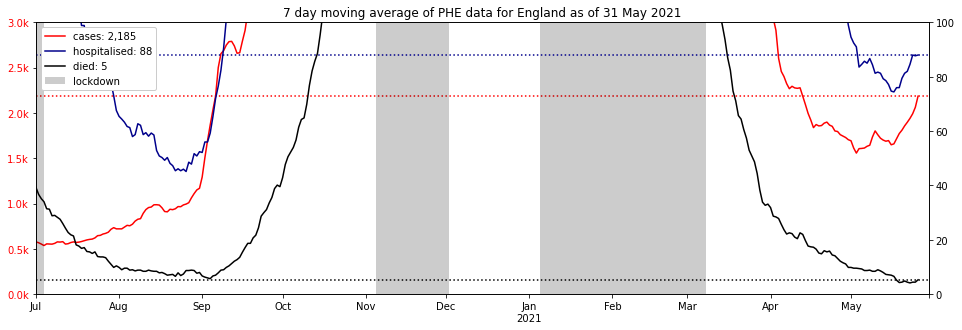

In [6]:
plot_summary(earliest_date='2020-07-01', show_latest='lines',
             left_series=(s.new_cases_sum,), left_formatter=per0k_formatter, left_ymax=3_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=100)

In [7]:
vaccination_changes()

,,Complete (Total),First Dose (Total),Second Dose (Total),Complete (New),First Dose (New),Second Dose (New)
,,,,,,,
England,30 May 21,"+21,719,461","+32,938,496","+21,719,461","+179,424","+99,213","+179,424"
Northern Ireland,30 May 21,"+661,490","+1,048,350","+661,490","+3,333","+4,203","+3,333"
Scotland,30 May 21,"+2,044,253","+3,251,138","+2,044,253","+21,525","+16,827","+21,525"
Wales,30 May 21,"+1,111,929","+2,141,427","+1,111,929",+0,+0,+0


,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,21719461.0,32938496.0,11219035.0,56286961,38.587020,19.931854,41.481126
1,Northern Ireland,N92000002,661490.0,1048350.0,386860.0,1893667,34.931696,20.429146,44.639158
2,Scotland,S92000003,2044253.0,3251138.0,1206885.0,5463300,37.417916,22.090769,40.491315
3,Wales,W92000004,1111929.0,2141427.0,1029498.0,3152879,35.267100,32.652633,32.080267


'partial: 39,379,411 (59.0%), full: 25,537,133'

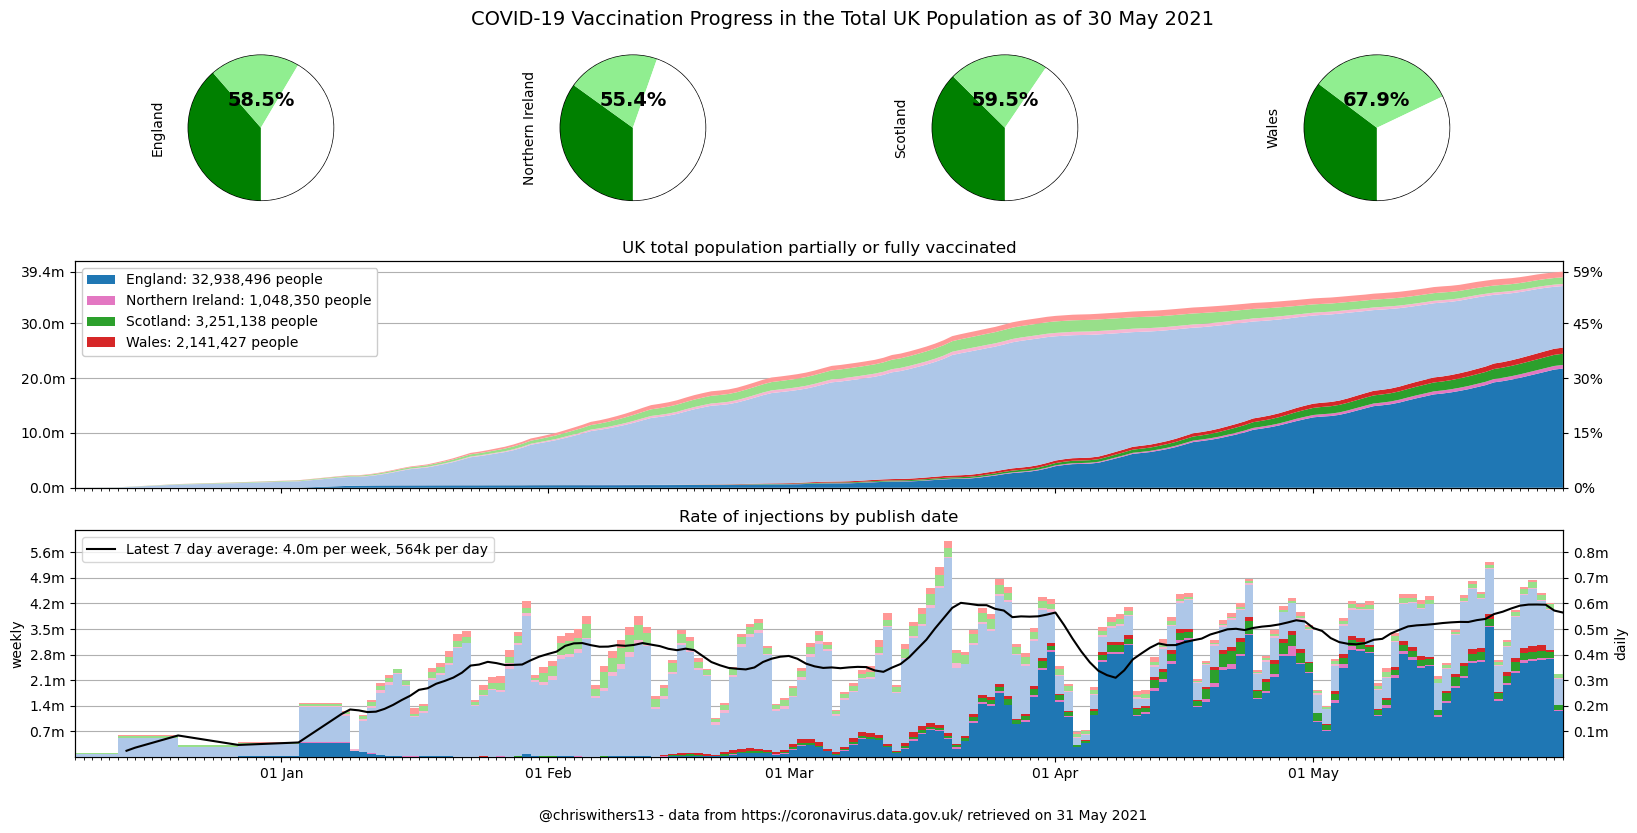

In [8]:
results = vaccination_dashboard()
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

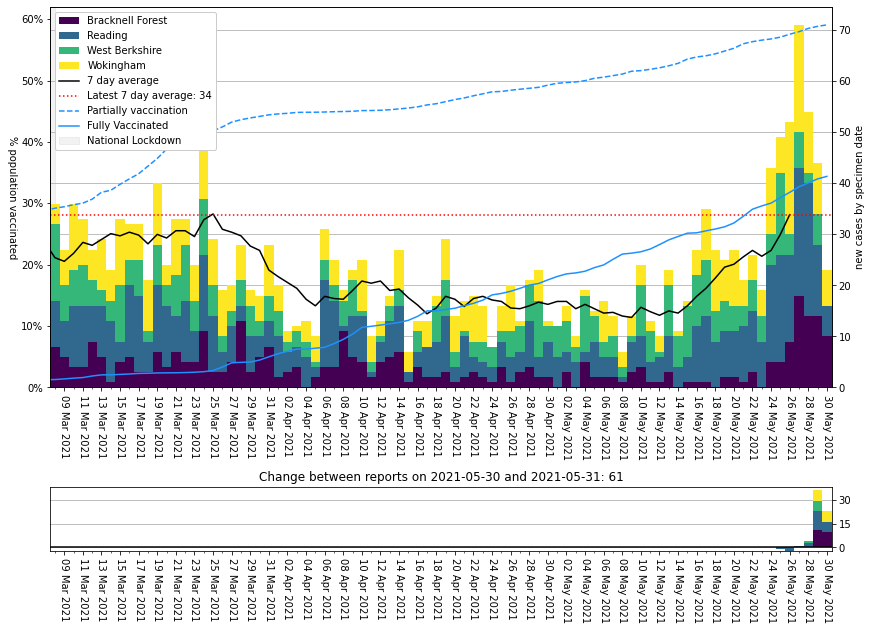

In [9]:
plot_areas(for_date, areas=my_areas, earliest=lockdown3[1],  lines=population_vaccinated)

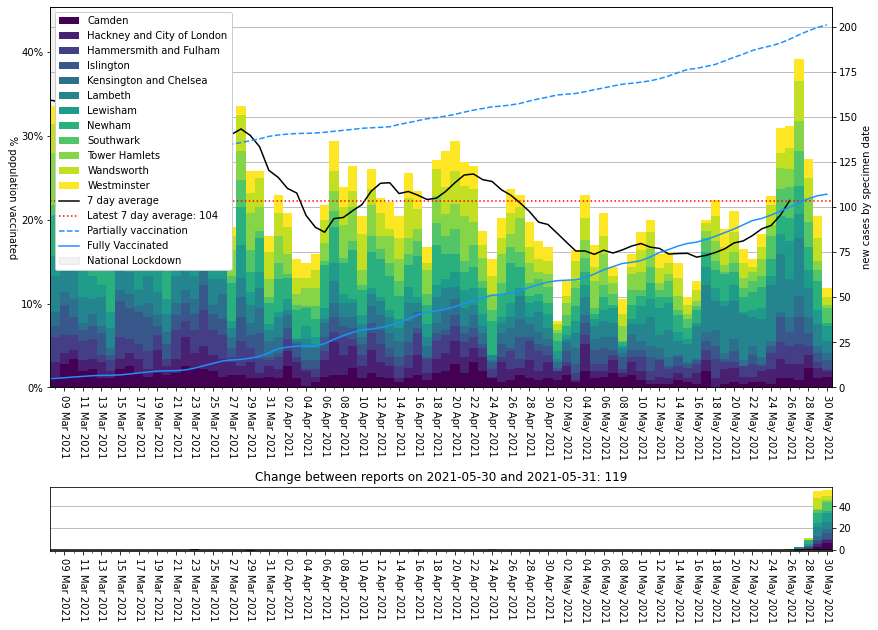

In [10]:
plot_areas(for_date, areas=london_areas, earliest=lockdown3[1], lines=population_vaccinated)

In [11]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [12]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E06000008,Blackburn with Darwen,404.820436,606.0,2021-05-30
E08000001,Bolton,342.201356,984.0,2021-05-30
E07000125,Rossendale,286.785484,205.0,2021-05-30
E07000120,Hyndburn,190.022581,154.0,2021-05-30
S12000011,East Renfrewshire,157.018738,150.0,2021-05-30
S12000038,Renfrewshire,155.778894,279.0,2021-05-30
E06000055,Bedford,144.842232,251.0,2021-05-30
E07000124,Ribble Valley,137.958218,84.0,2021-05-30
E07000123,Preston,127.152688,182.0,2021-05-30


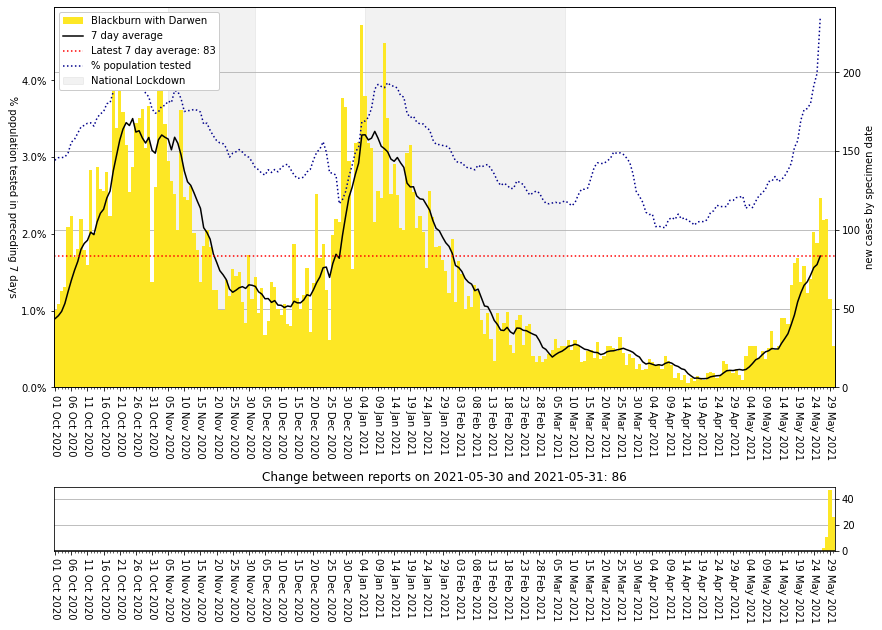

In [13]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [14]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000001,Bolton,342.201356,984.0,2021-05-30
S12000049,Glasgow City,117.987111,747.0,2021-05-30
E08000003,Manchester,122.092834,675.0,2021-05-30
E06000008,Blackburn with Darwen,404.820436,606.0,2021-05-30
E08000025,Birmingham,40.549441,463.0,2021-05-30
E08000034,Kirklees,105.050854,462.0,2021-05-30
S12000036,City of Edinburgh,82.296687,432.0,2021-05-30
E08000035,Leeds,42.867644,340.0,2021-05-30
E08000006,Salford,123.631362,320.0,2021-05-30


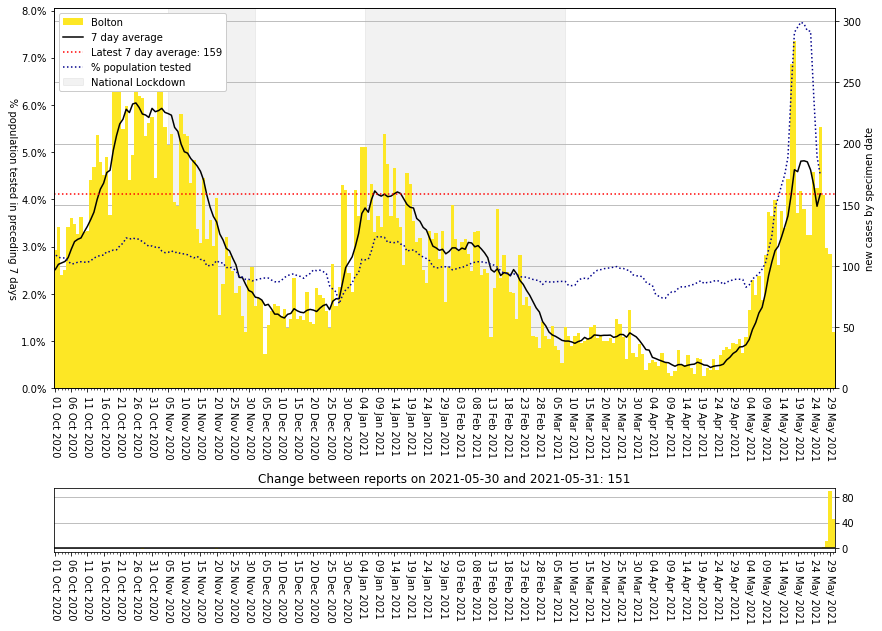

In [15]:
plot_areas(for_date, areas=[top_10.iloc[0].name], colormap='viridis_r', lines=unique_people_tested)

In [16]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 0.6
phe_max = 0.25

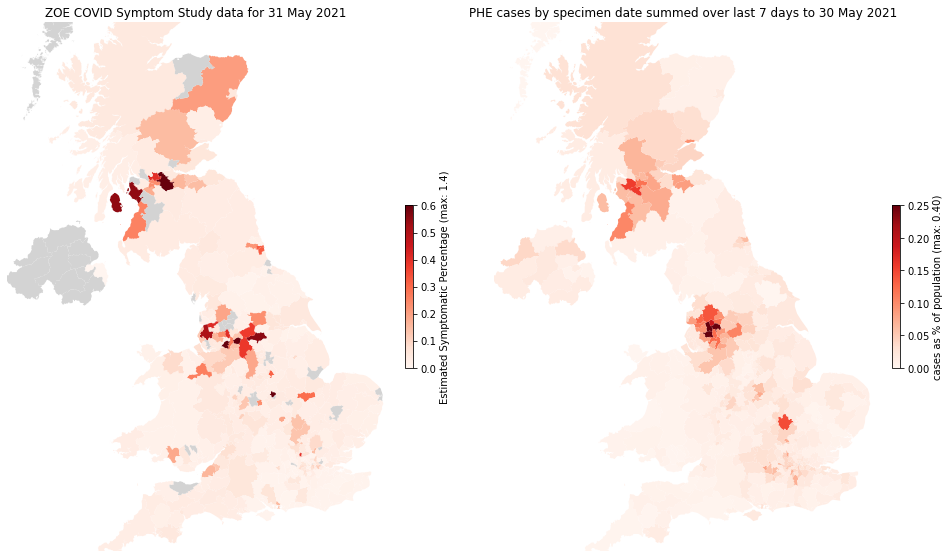

In [17]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [18]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...